## Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

import re
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.regression.linear_model as sm

nltk.download(['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger'])\

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

[nltk_data] Downloading package punkt to /home/nabanita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nabanita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nabanita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nabanita/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Exploratory Data Analysis

Let's load the data and look at few entries.

In [2]:
df = pd.read_csv("listings.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [3]:
# drop the column 'Unnamed: 0'
del df["Unnamed: 0"]

In [4]:
print("The shape of our dataframe is : {}".format(df.shape))

The shape of our dataframe is : (2253, 15)


What are the types of different features present in the dataset?

In [5]:
df.dtypes

Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
Easy Apply            object
dtype: object

Except 'Rating' and 'Founded' all other features are defined as 'object' type. Let's find out how many columns have null values.

In [6]:
df.isnull().sum()

Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         1
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
Easy Apply           0
dtype: int64

Only the column 'Company Name' has one missing value. But when we look at the data closely, we find that there are some entries like '-1',-1, 'Unknown' in the dataframe. These values are equivalent to NaNs. An easy way to find this out is to look at the unique elements in each column. 

In [7]:
# number of unique elements in each column
df.nunique()

Job Title            1272
Salary Estimate        90
Job Description      2253
Rating                 37
Company Name         1513
Location              253
Headquarters          483
Size                    9
Founded               161
Type of ownership      15
Industry               89
Sector                 25
Revenue                14
Competitors           291
Easy Apply              2
dtype: int64

Let's look at unique values in some of these columns.

In [8]:
df['Rating'].unique()

array([ 3.2,  3.8,  3.4,  4.1,  3.9,  4.4,  3.7,  4. , -1. ,  3. ,  3.6,
        4.9,  3.3,  3.5,  5. ,  4.8,  4.7,  4.6,  2.9,  1. ,  3.1,  4.5,
        2.3,  4.2,  2.8,  4.3,  2.7,  2.5,  2.6,  2.4,  2. ,  2.1,  1.7,
        2.2,  1.8,  1.6,  1.9])

In [9]:
df['Size'].unique()

array(['201 to 500 employees', '10000+ employees',
       '1001 to 5000 employees', '501 to 1000 employees',
       '5001 to 10000 employees', '1 to 50 employees',
       '51 to 200 employees', 'Unknown', '-1'], dtype=object)

So, we replace all these above mentioned entries by NaNs.

In [5]:
df.replace([-1.,-1, '-1', 'Unknown', 'Unknown / Non-Applicable'], np.nan, inplace=True)

In [11]:
# check our dataframe after the replacement
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),NaN,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),NaN,NaN
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,NaN,GoDaddy,NaN
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),NaN,NaN
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


After this replacement, we check again the number of null values in each of the features.

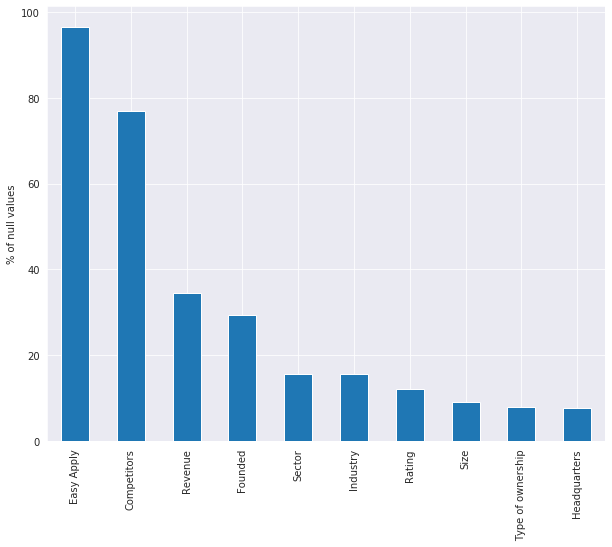

In [6]:
# calculate % of null value in each column and sort them in descending order
null_percentage = df.isnull().sum().sort_values(ascending=False)/len(df)*100

# make a plot
null_percentage[null_percentage>0.1].plot(kind='bar', figsize=(10,8))
plt.ylabel("% of null values");

As we can see from the above plot, most of the entries in 'Easy Apply' and 'Competitors' are missing. Therefore, we will drop these two columns. 

In [13]:
df.drop(['Easy Apply', 'Competitors'], axis=1, inplace=True)
print("The shape of the dataframe after dropping features : {}".format(df.shape))

The shape of the dataframe after dropping features : (2253, 13)


Let's now calculate null value percentage in each row of the dataframe.

In [14]:
# calculate % of null value in each row and sort them in descending order
row_null_percentage = df.isnull().sum(axis=1).sort_values(ascending=False)/len(df)*100
row_null_percentage

1860    0.399467
1168    0.355082
1459    0.355082
1940    0.355082
253     0.355082
          ...   
1284    0.000000
1288    0.000000
1289    0.000000
1291    0.000000
0       0.000000
Length: 2253, dtype: float64

None of the row has significant amount of null values and therefore no row can be dropped on the basis of null value percentage. 

The first question that one can ask is that **which industries are hiring data analysts actively at present?** 

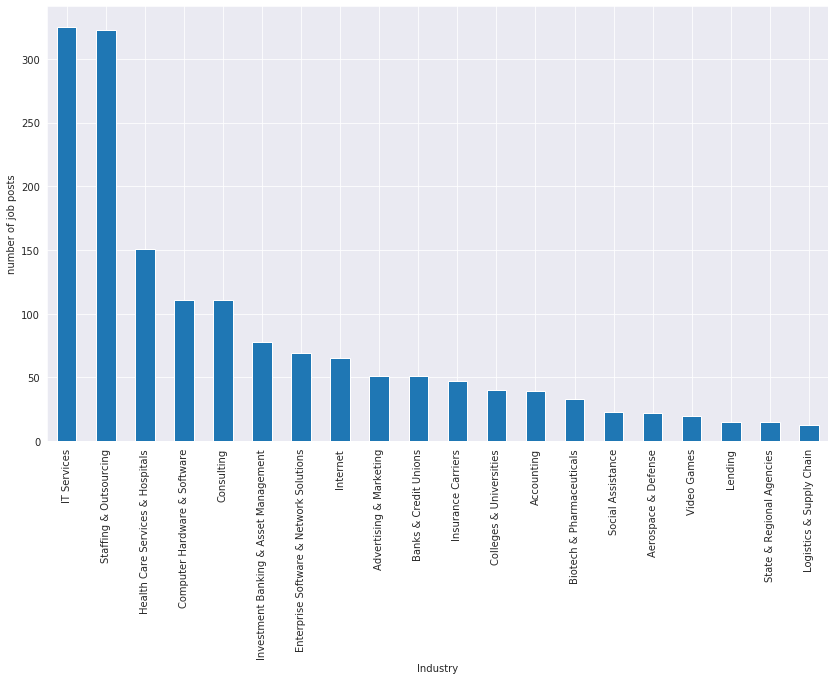

In [15]:
df['Industry'].value_counts()[:20].plot(kind='bar', figsize=(14,8))
plt.xlabel("Industry")
plt.ylabel("number of job posts");

Most of the data analyst job posts are in the IT and Staffing & Outsourcing sectors. Current data analyst post vacancy in the Health Care sector is almost half of these two.

The next interesting question could be **What is the distribution of salary across all the industries?** Let's look at the column 'Salary Estimate'.

In [16]:
# first 10 entries in 'Salary Estimate'
df['Salary Estimate'][:10]

0    $37K-$66K (Glassdoor est.)
1    $37K-$66K (Glassdoor est.)
2    $37K-$66K (Glassdoor est.)
3    $37K-$66K (Glassdoor est.)
4    $37K-$66K (Glassdoor est.)
5    $37K-$66K (Glassdoor est.)
6    $37K-$66K (Glassdoor est.)
7    $37K-$66K (Glassdoor est.)
8    $37K-$66K (Glassdoor est.)
9    $37K-$66K (Glassdoor est.)
Name: Salary Estimate, dtype: object

We need to clean this. We create three new features from this column - minimum, maximum and average salaries offered in different industries and then drop the original feature.

In [7]:
# the minimum salary offered
df['min_salary'] = df['Salary Estimate'].apply(lambda x:float(x.split()[0].split("-")[0].strip("$,K")) 
                                                          if not pd.isnull(x) else x)

# the maximum salary offered
df['max_salary'] = df['Salary Estimate'].apply(lambda x:float(x.split()[0].split("-")[1].strip("$,K")) 
                                                          if not pd.isnull(x) else x)

# the average salary offered
df['avg_salary'] = (df['min_salary'] + df['max_salary'])/2.

In [8]:
# drop the original column
df.drop('Salary Estimate', axis=1, inplace=True)

In [14]:
#find_str = 'analyst'
#df['Job Title'] = df['Job Title'].apply(lambda x:x[:(x.lower()).find(find_str)+len(find_str)].lower())

Now we can look at the distribution of average salary in different industries.

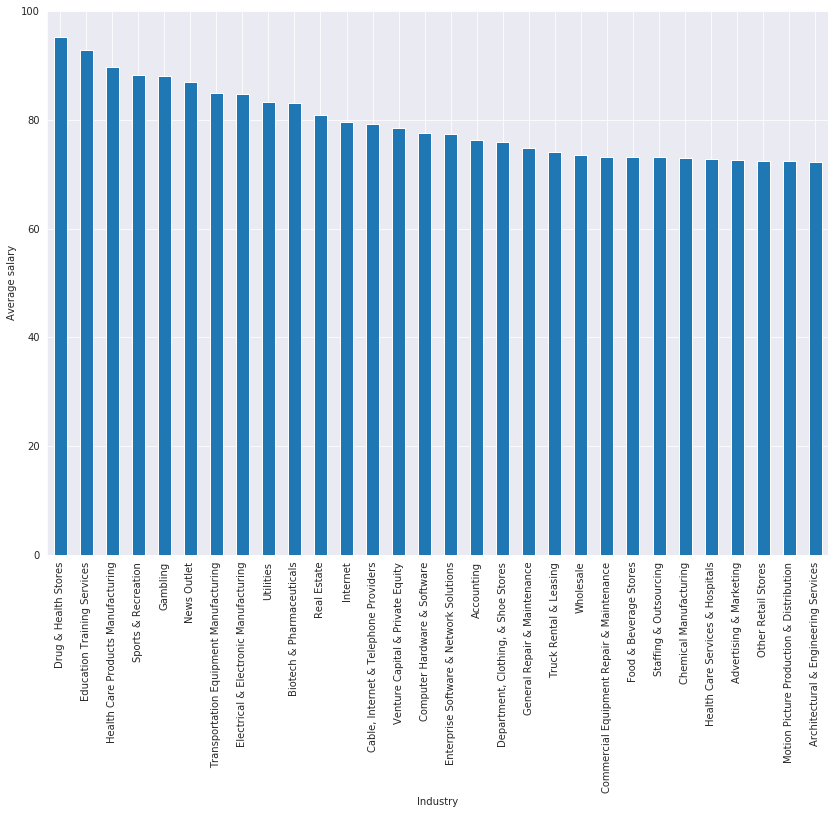

In [19]:
# plot top 30 industries with highest offered salaries
df.groupby('Industry')['avg_salary'].mean().sort_values(ascending=False)[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Industry')
plt.ylabel('Average salary');

This is interesting! Although IT sector has maximum number of job postings, the salary offered does not fall into top 30. The healthcare industry ('Drug & Health Stores', 'Health Care Products Manufacturing', 'Biotech & Pharmaceuticals', 'Health Care Services & Hospitals') generally has a high average salary. The average salary offered in education industry is almost comparable to that of healthcare industry. This plot tells us that even if some industries have fewer job postings, they offer better salaries.

**Which companies are hiring data analysts actively?** Let's look at the column 'Company Name'.

In [20]:
df['Company Name'].unique()[:20]

array(['Vera Institute of Justice\n3.2',
       'Visiting Nurse Service of New York\n3.8', 'Squarespace\n3.4',
       'Celerity\n4.1', 'FanDuel\n3.9', 'Point72\n3.9', 'Two Sigma\n4.4',
       'GNY Insurance Companies\n3.7', 'DMGT\n4.0', 'Riskified\n4.4',
       'NYU Langone Health\n4.0', 'BulbHead', 'Montefiore Medical\n3.7',
       'Known\n3.0', 'Advisor Group\n3.4', 'CodeGreen Solutions\n3.6',
       'Undertone\n3.8', 'NYSTEC\n3.8',
       'Education Development Center, Inc.\n3.9',
       'Teachers Pay Teachers\n4.9'], dtype=object)

In [21]:
# extract only the company name
df['Company Name'] = df['Company Name'].apply(lambda x:x.split("\n")[0].strip() 
                                                       if not pd.isnull(x) else x)

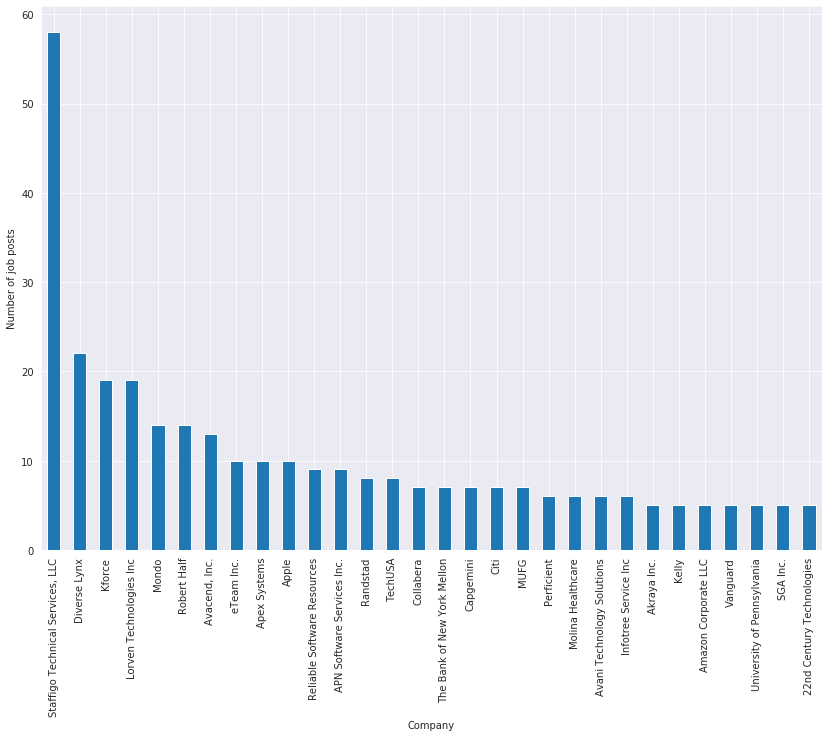

In [22]:
# plot top 30 companies with high job postings
df['Company Name'].value_counts()[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Company')
plt.ylabel('Number of job posts');

**Which companies are offering high salaries?**

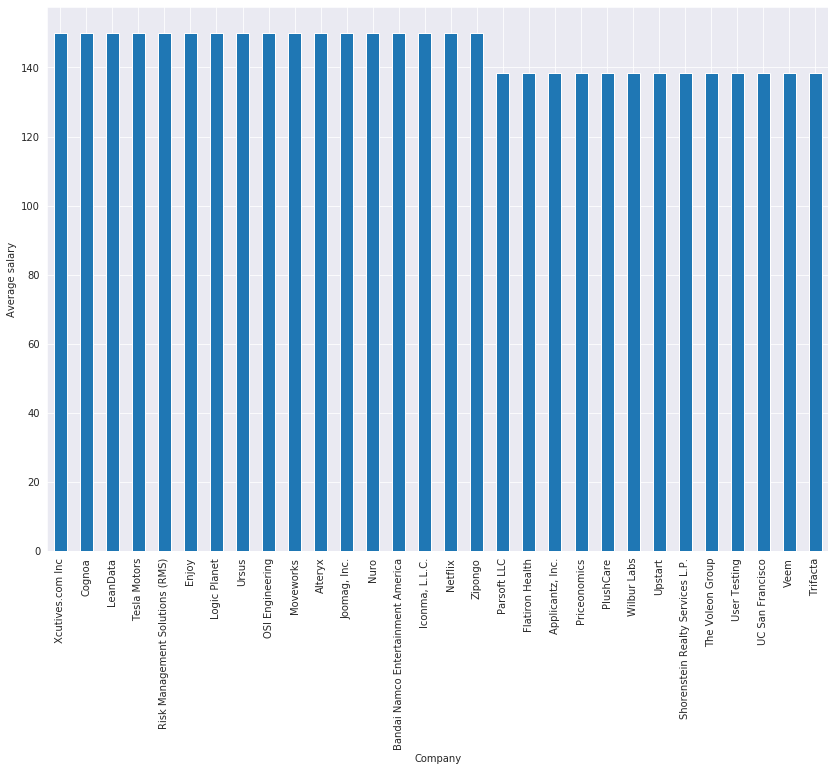

In [23]:
# plot top 30 companies with high average salaries
df.groupby('Company Name')['avg_salary'].mean().sort_values(ascending=False)[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Company')
plt.ylabel('Average salary');

Let's study these companies closely.

In [24]:
# store top 30 companies offering high salaries in a list
top_30_comps = list(df.groupby('Company Name')['avg_salary'].mean().sort_values(ascending=False)[:30].index)

**How are the ratings of these companies?**

In [25]:
print("The rating is given on a scale {}-{}.".format(df['Rating'].min(), df['Rating'].max()))

The rating is given on a scale 1.0-5.0.


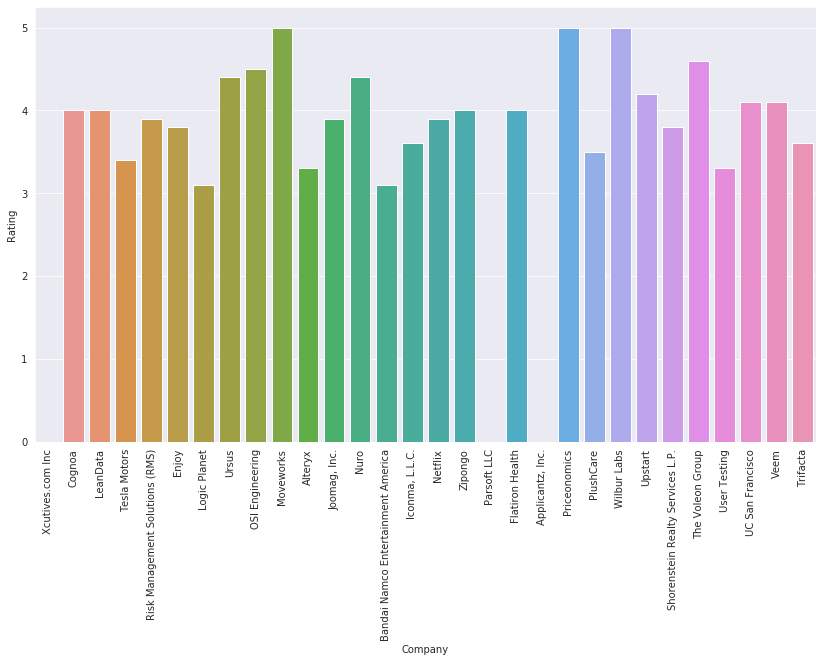

In [26]:
# plot ratings of these companies
plt.figure(figsize=(14,8))
sns.barplot(x=df[df['Company Name'].isin(top_30_comps)]['Company Name'], 
            y=df[df['Company Name'].isin(top_30_comps)]['Rating'],
            order = top_30_comps)
plt.xlabel('Company')
plt.xticks(rotation=90);

All the companies (except three) have a minimum rating value 3. 'Xcutives.com Inc', 'Applicantz, Inc' and 'Parsoft LLC' - although these three companies are offering high salaries to candidates, no rating is available for them. One reason might be that these are comparatively new companies.

**What about numbe of currently employed staffs in these companies?** The relevant feature for this question is 'Size'.

In [27]:
# unique values in the feature 'Size'
df['Size'].unique()

array(['201 to 500 employees', '10000+ employees',
       '1001 to 5000 employees', '501 to 1000 employees',
       '5001 to 10000 employees', '1 to 50 employees',
       '51 to 200 employees', nan], dtype=object)

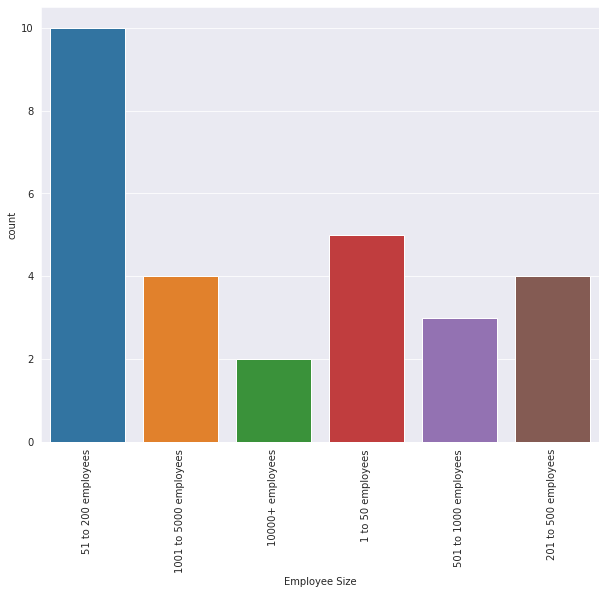

In [28]:
# Employee size of top 30 high paying companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Size'])   
plt.xlabel('Employee Size')
plt.xticks(rotation=90);

Surprisingly, most of the high paying companies are small in size. These are likely to be start-ups. So the data is telling us that start-ups are likely to pay more to data analysts as compared to big companies.

Another important question to explore could be **what are the financial status of these companies?** To find an answer to this, we look at the available feature 'Revenue'.

In [29]:
# unique values in 'Revenue'
df['Revenue'].unique()

array(['$100 to $500 million (USD)', '$2 to $5 billion (USD)', nan,
       '$50 to $100 million (USD)', '$1 to $2 billion (USD)',
       '$5 to $10 billion (USD)', '$1 to $5 million (USD)',
       '$25 to $50 million (USD)', '$10+ billion (USD)',
       'Less than $1 million (USD)', '$10 to $25 million (USD)',
       '$500 million to $1 billion (USD)', '$5 to $10 million (USD)'],
      dtype=object)

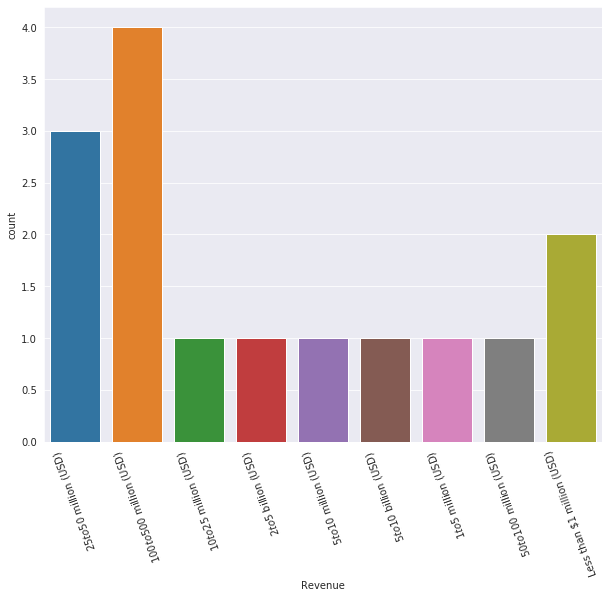

In [30]:
# plot revenues of top 30 high paying companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Revenue'])    
plt.xticks(rotation=110);

The plot reiterates the same thing - most of the data analyst job positions are available in companies of small and moderate sizes.

One more question in this chain - **where are these companies located?**

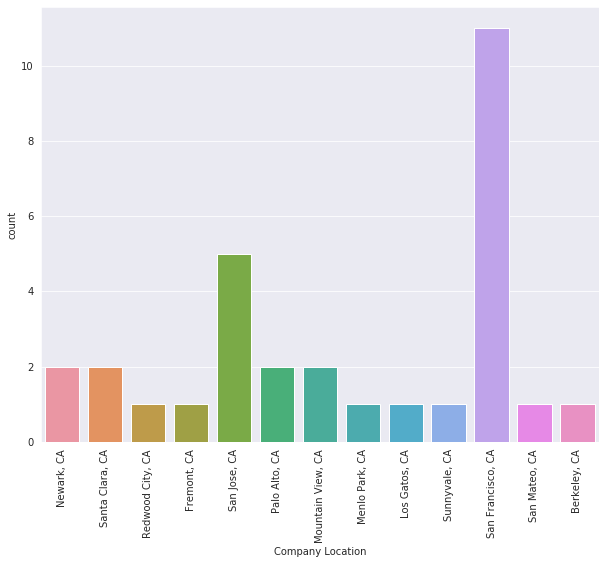

In [31]:
# plot locations of these top 30 companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Location'])    
plt.xlabel("Company Location")
plt.xticks(rotation=90);

All these companies are situated in CA! All the information that we gathered from this exercise can be summarized as follows:

**Companies offering high salaries to data analysts are small in size with average total revenue, generally have decent ratings and are mostly situated in CA.** 

Next, we ask the following two questions:

- Do older companies pay more as compared to new ones?
- Where do we have high paying jobs?

Let's start with the first one. We can use the feature 'Founded' to compute the 'age' of a company.

In [12]:
current_year = datetime.datetime.now().year

# compute the age
df['Company_age'] = current_year - df['Founded']

# drop the original feature
df.drop('Founded', axis=1, inplace=True)

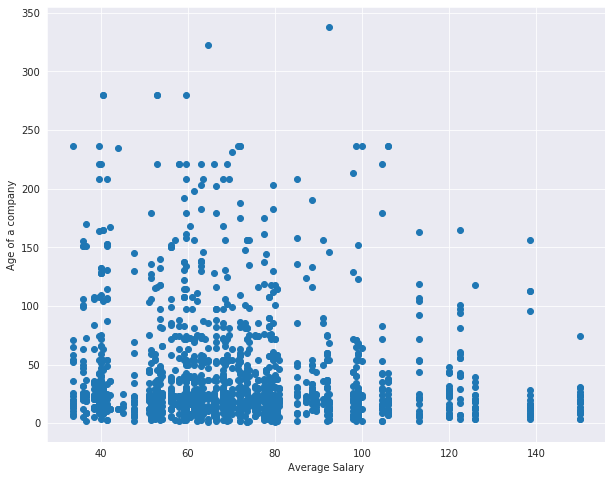

In [33]:
# plot avg. salary vs age of a company
plt.figure(figsize=(10,8))
plt.scatter(x='avg_salary', y='Company_age', data=df)
plt.xlabel('Average Salary')
plt.ylabel('Age of a company');

Therefore, we see that comparatively new companies pay more to data analysts than older companies.

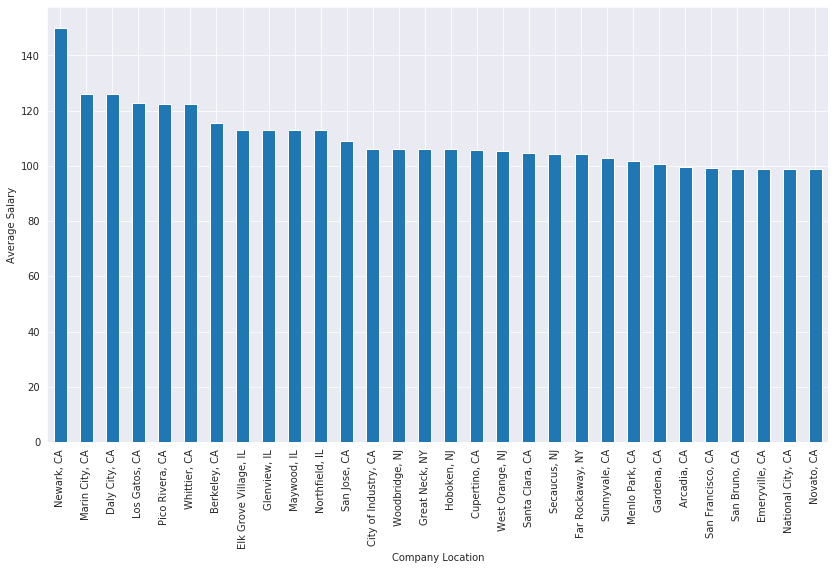

In [34]:
# plot top 30 locations offering high salaries to data analysts 
df.groupby('Location')['avg_salary'].mean().sort_values(ascending=False)[:30].plot(kind='bar', figsize=(14,8))
plt.xlabel('Company Location')
plt.ylabel('Average Salary');

Most of the high paying job positions are in CA. So, if you are looking for a career in data analytics, CA might be you next destination!

To get a job, you must have the required skill sets. **What skills are companies looking for in a data analyst?** The feature of interest in this case is 'Job Description'.

In [35]:
# store job descriptions separately
description_text = df['Job Description']
description_text

0       Are you eager to roll up your sleeves and harn...
1       Overview\n\nProvides analytical and technical ...
2       We’re looking for a Senior Data Analyst who ha...
3       Requisition NumberRR-0001939\nRemote:Yes\nWe c...
4       ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...
                              ...                        
2248    Maintains systems to protect data from unautho...
2249    Position:\nSenior Data Analyst (Corporate Audi...
2250    Title: Technical Business Analyst (SQL, Data a...
2251    Summary\n\nResponsible for working cross-funct...
2252    You.\n\nYou bring your body, mind, heart and s...
Name: Job Description, Length: 2253, dtype: object

Below we perform text cleaning to extract relevant words from these descriptions.

In [36]:
def text_to_word(text):
    
    """
    
    
    
    """

    word_list =  word_tokenize(re.sub(r"[^a-z]", " ", text.lower()))
    word_nostop_list = [word for word in word_list if word not in stopwords.words("english")]
    pos_dict = {"N":wordnet.NOUN, "J":wordnet.ADJ} # "V":wordnet.VERB, , , "R":wordnet.ADV
    
    lemm_token_list = set()
    for token,pos_tag in nltk.pos_tag(word_nostop_list):
        try:
            lemm_token_list.add(WordNetLemmatizer().lemmatize(token, pos=pos_dict[pos_tag[0]]))
        except:
            pass

    
    cleaned_text = ' '.join(lemm_token_list)
        
    return cleaned_text

In [37]:
df['cleaned_description'] = df['Job Description'].apply(lambda x:text_to_word(x))

Let's find out average lengths of available job descriptions in the dataset after text cleaning.

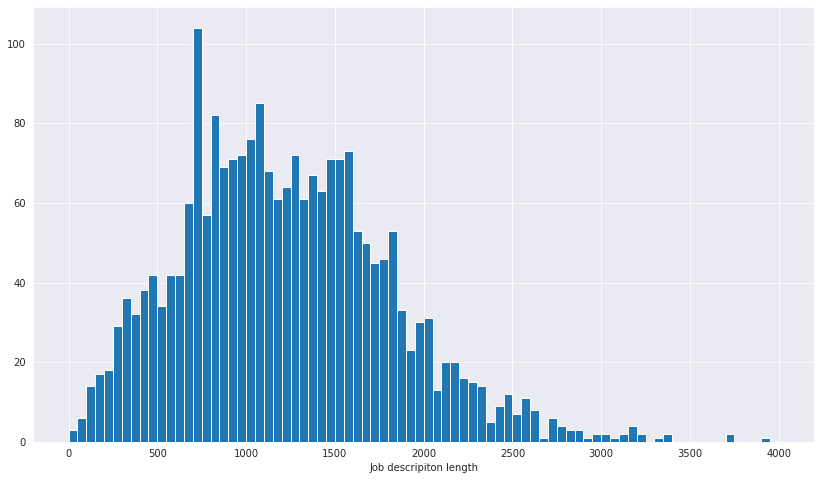

In [38]:
desc_len = [len(desc) for desc in df['cleaned_description']]
plt.figure(figsize=(14,8))
plt.xlabel('Job descripiton length')
plt.hist(desc_len, bins=80, range=(0,4000));

So even after the text cleaning, most of the descriptions tend to be long with an average length lying approximately in the range 1000-1500. Extracting *skill keywords* from this huge corpus is not going to be straighforward.

In [39]:
count_vect = CountVectorizer(ngram_range=(1,1)).fit(df['cleaned_description'])
df_matrix = count_vect.transform(df['cleaned_description'])

In [40]:
print("The shape of the document-term matrix is : {}".format(df_matrix.shape))

The shape of the document-term matrix is : (2253, 13326)


In [41]:
# get top 10 unigrams

def top_n_unigram(document, n):
    
    count_vect = CountVectorizer(ngram_range=(1,1))
    dt_matrix = count_vect.fit_transform(document)
    
    word_freq = dt_matrix.sum(axis=0)/df_matrix.shape[0]
    word_freq_list = [(word, word_freq[0, index]) for word, index in count_vect.vocabulary_.items()]
    word_freq_list = sorted(word_freq_list, key=lambda x:x[1], reverse=True)
    
    return word_freq_list[:n]

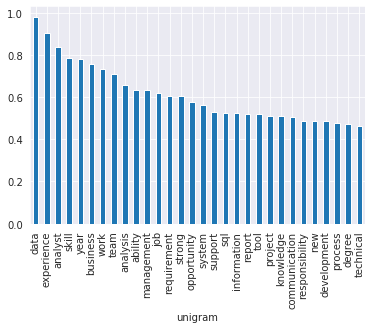

In [42]:
top_unigrams = top_n_unigram(df['cleaned_description'], 30)
df2 = pd.DataFrame(top_unigrams, columns = ['unigram' , 'count'])
df2.set_index('unigram', inplace=True)
df2['count'].plot(kind='bar')

In [53]:
lda = LatentDirichletAllocation()
new_mat = lda.fit_transform(df_matrix)

In [37]:
new_mat.shape

(2253, 10)

In [26]:
#lda.components_

In [54]:
keywords = np.array(count_vect.get_feature_names())

In [26]:
keywords.shape

(15506,)

In [55]:
topic_keywords = []

for topic_weights in lda.components_:
    top_keyword_locs = (-topic_weights).argsort()[:5]
    topic_keywords.append(keywords.take(top_keyword_locs))
    
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords

,0,1,2,3,4
0,data,experience,year,analysis,benefit
1,service,data,year,analyst,business
2,data,analyst,experience,skill,year
3,data,job,support,analyst,experience
4,race,sexual,origin,orientation,disability
5,year,member,team,analyst,responsibility
6,data,report,experience,year,system
7,data,experience,analyst,business,team
8,team,year,data,work,experience
9,data,experience,business,skill,strong


## Salary prediction 

In this section, we build a regression model, which given a set of features, would be able to predict average salary of a data analyst job post. Since our target variable is 'avg_salary', any null value present in it should be removed. 

In [9]:
df.isnull().sum()

Job Title               0
Job Description         0
Rating                272
Company Name            1
Location                0
Headquarters          172
Size                  205
Founded               660
Type of ownership     179
Industry              353
Sector                353
Revenue               778
Competitors          1732
Easy Apply           2173
min_salary              1
max_salary              1
avg_salary              1
dtype: int64

So, 'avg_salary' has one null value. Let's remove the corresponding row from our dataset.

In [10]:
print("The shape of the dataframe before removing null values {}".format(df.shape))
df.dropna(subset=['avg_salary'], inplace=True)
print("The shape of the dataframe after removing null values {}".format(df.shape))

The shape of the dataframe before removing null values (2253, 17)
The shape of the dataframe after removing null values (2252, 17)


Let's now define our feature matrix and the target variable.

In [57]:
# Feature matrix
#X = df[['Rating', 'Location', 'Size', 'Revenue', 'Company_age']]
#X = df[['Location', 'Revenue', 'Company_age']]
X = df[['Location', 'Company_age']]

# Target variable
y = df['avg_salary']

In [58]:
# look at first few entries in the feature matrix
X.head()

,Location,Company_age
0,"New York, NY",59.0
1,"New York, NY",127.0
2,"New York, NY",17.0
3,"New York, NY",18.0
4,"New York, NY",11.0


So, we have three categorical features and should convert them to dummy variables before fitting into the model. How many unique values are present in each of these categorical variables?

In [80]:
X[['Location', 'Size', 'Revenue']].nunique()

Location    253
Size          7
Revenue      12
dtype: int64

The feature 'Location' has a large number of categories. What are these?

In [81]:
# categories present in 'Location'
X['Location'].unique()

array(['New York, NY', 'Fairfield, NJ', 'Jersey City, NJ', 'Brooklyn, NY',
       'Weehawken, NJ', 'Long Island City, NY', 'Florham Park, NJ',
       'Manhasset, NY', 'Newark, NJ', 'Queens Village, NY', 'Haworth, NJ',
       'Fort Lee, NJ', 'South Plainfield, NJ', 'Bronx, NY',
       'Little Ferry, NJ', 'Lake Success, NY', 'Summit, NJ',
       'Valley Stream, NY', 'Berkeley Heights, NJ', 'Essex Fells, NJ',
       'Franklin Lakes, NJ', 'Mount Vernon, NY', 'Secaucus, NJ',
       'West Orange, NJ', 'Far Rockaway, NY', 'Woodbridge, NJ',
       'Parsippany, NJ', 'Whippany, NJ', 'Great Neck, NY', 'Hoboken, NJ',
       'Staten Island, NY', 'Harrison, NY', 'Iselin, NJ', 'Montvale, NJ',
       'Woodcliff Lake, NJ', 'Salt Lake City, UT', 'West Jordan, UT',
       'Lehi, UT', 'Draper, UT', 'American Fork, UT', 'Sandy, UT',
       'Riverton, UT', 'Reedley, CA', 'Visalia, CA', 'Hanford, CA',
       'Hampton, VA', 'Norfolk, VA', 'Portsmouth, VA', 'Chesapeake, VA',
       'Smithfield, VA', 'Suffolk, 

Let's extract only the state names from these locations.

In [59]:
X['Location'] = X['Location'].apply(lambda x:x.split(",")[-1].strip())

# revised categories in the feature 'Location'
X['Location'].unique()

array(['NY', 'NJ', 'UT', 'CA', 'VA', 'FL', 'IL', 'TX', 'AZ', 'PA', 'DE',
       'OH', 'NC', 'SC', 'IN', 'WA', 'GA', 'KS', 'CO'], dtype=object)

In [114]:
# number of categories 
X['Location'].nunique()

19

So, categories in the feature 'Location' drops from 253 to 19 after this step. We have already seen that this feature does not contain any null value. So, let's create dummy variables for this feature first.

In [60]:
location_df = pd.get_dummies(X['Location'], drop_first=True, prefix='State')
X = pd.concat([X, location_df], axis=1)
X.drop('Location', axis=1, inplace=True)

In [61]:
X.shape

(2252, 19)

In [86]:
# categories present in 'Size'
X['Size'].unique()

array(['201 to 500 employees', '10000+ employees',
       '1001 to 5000 employees', '501 to 1000 employees',
       '5001 to 10000 employees', '1 to 50 employees',
       '51 to 200 employees', nan], dtype=object)

In [117]:
# categories present in 'Revenue'
X['Revenue'].unique()

array(['$100 to $500 million (USD)', '$2 to $5 billion (USD)', nan,
       '$50 to $100 million (USD)', '$1 to $2 billion (USD)',
       '$5 to $10 billion (USD)', '$1 to $5 million (USD)',
       '$25 to $50 million (USD)', '$10+ billion (USD)',
       'Less than $1 million (USD)', '$10 to $25 million (USD)',
       '$500 million to $1 billion (USD)', '$5 to $10 million (USD)'],
      dtype=object)

In [62]:
# percentage of null values in the feature matrix
X.isnull().sum()/len(X)*100

Company_age    29.307282
State_CA        0.000000
State_CO        0.000000
State_DE        0.000000
State_FL        0.000000
State_GA        0.000000
State_IL        0.000000
State_IN        0.000000
State_KS        0.000000
State_NC        0.000000
State_NJ        0.000000
State_NY        0.000000
State_OH        0.000000
State_PA        0.000000
State_SC        0.000000
State_TX        0.000000
State_UT        0.000000
State_VA        0.000000
State_WA        0.000000
dtype: float64

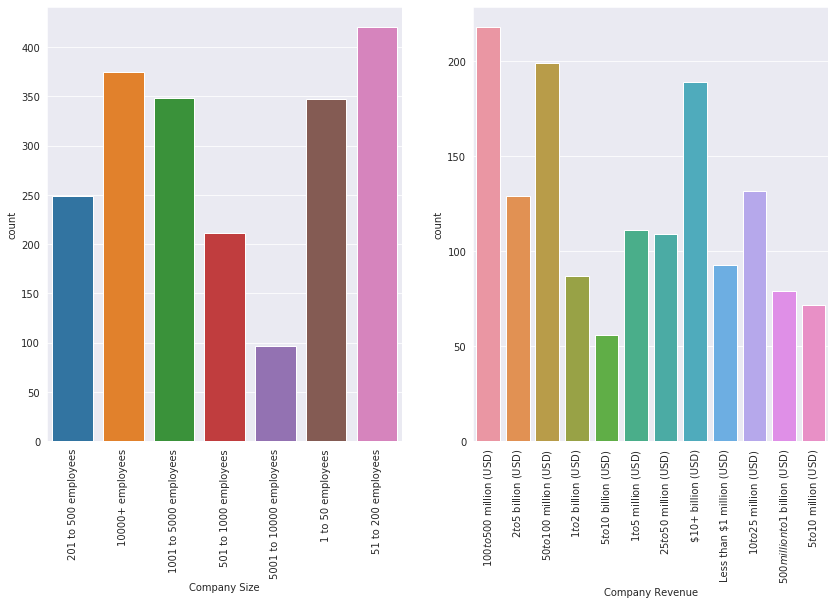

In [54]:
# distribution of categories in the categorical features present in the feature matrix
fig, ax = plt.subplots(1,2,figsize=(14,8))
sns.countplot(X['Size'], ax=ax[0])
sns.countplot(X['Revenue'], ax=ax[1])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[0].set_xlabel('Company Size')
ax[1].set_xlabel('Company Revenue');

We impute null values in the categorical columns using the method 'most_frequent'. 

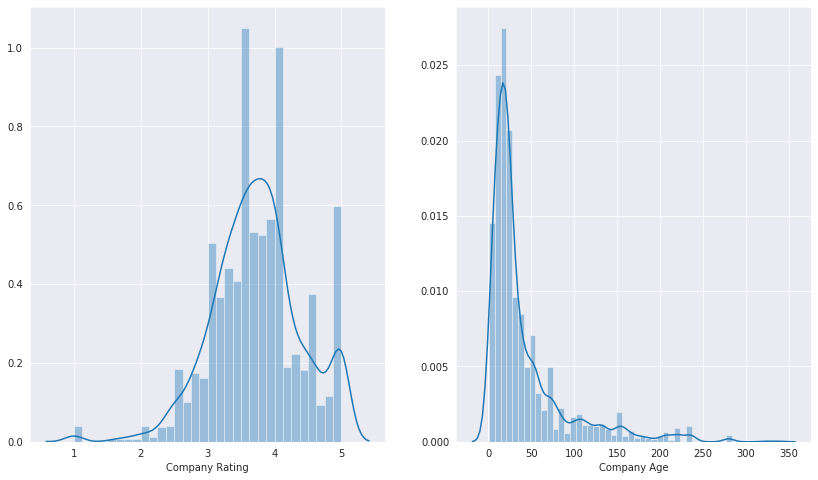

In [55]:
# distribution of numerical features present in the feature matrix
fig, ax = plt.subplots(1,2,figsize=(14,8))
sns.distplot(X['Rating'], ax=ax[0])
sns.distplot(X['Company_age'], ax=ax[1])
ax[0].set_xlabel('Company Rating')
ax[1].set_xlabel('Company Age');

The feature 'Rating' follows approximately a normal distribution. On the other hand, most of the values in 'Company_age' lie between 0 and 50. We impute numerical features using the method 'mean'. But before performing imputation, let's split our dataset into train and test subsets.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
print("The shape of the training set : {}".format(X_train.shape))
print("The shape of the test set : {}".format(X_test.shape))

The shape of the training set : (1801, 19)
The shape of the test set : (451, 19)


In [64]:
# imputation of null values

# categorical features
imputer_cat = SimpleImputer(strategy="most_frequent")
#X_train[['Size', 'Revenue']] = imputer_cat.fit_transform(X_train[['Size', 'Revenue']])
#X_test[['Size', 'Revenue']] = imputer_cat.transform(X_test[['Size', 'Revenue']])
#X_train[['Revenue']] = imputer_cat.fit_transform(X_train[['Revenue']])
#X_test[['Revenue']] = imputer_cat.transform(X_test[['Revenue']])

# numerical features
imputer_num = SimpleImputer(strategy="mean")
#X_train[['Rating', 'Company_age']] = imputer_num.fit_transform(X_train[['Rating', 'Company_age']])
#X_test[['Rating', 'Company_age']] = imputer_num.transform(X_test[['Rating', 'Company_age']])
X_train[['Company_age']] = imputer_num.fit_transform(X_train[['Company_age']])
X_test[['Company_age']] = imputer_num.transform(X_test[['Company_age']])

The next job is create dummy variables for the categorical features.

In [65]:
# create dummy variables for each categorical feature
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train.head()

,Company_age,State_CA,State_CO,State_DE,State_FL,State_GA,State_IL,State_IN,State_KS,State_NC,State_NJ,State_NY,State_OH,State_PA,State_SC,State_TX,State_UT,State_VA,State_WA
1954,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
615,17.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565,6.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2086,22.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1308,60.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Finally, we scale the numerical features present in the dataset.

In [66]:
# feature scaling
scaler = MinMaxScaler(feature_range=(0,1))

X_train[['Company_age']] = scaler.fit_transform(X_train[['Company_age']])
X_test[['Company_age']] = scaler.transform(X_test[['Company_age']])

X_train.head()

,Company_age,State_CA,State_CO,State_DE,State_FL,State_GA,State_IL,State_IN,State_KS,State_NC,State_NJ,State_NY,State_OH,State_PA,State_SC,State_TX,State_UT,State_VA,State_WA
1954,0.010753,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
615,0.057348,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
565,0.017921,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2086,0.075269,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1308,0.211470,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [125]:
X_train['Company_age'].max(), X_train['Company_age'].min(), X_test['Company_age'].max(), X_test['Company_age'].min()

(0.9999999999999999, 0.0, 1.2078853046594984, 0.0)

In [67]:
print("The final shape of our dataframe is : {}".format(X_train.shape))

The final shape of our dataframe is : (1801, 19)


In [68]:
# support vector regressor
svr = SVR(kernel='sigmoid', C=0.5)
svr.fit(X_train, y_train)

SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [69]:
svr_pred = svr.predict(X_test)
rmse_svr_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
rmse_svr_test = mean_squared_error(y_test, svr_pred, squared=False)
r2_svr_train = r2_score(y_train, svr.predict(X_train))
r2_svr_test = r2_score(y_test, svr_pred)

print("Training scores")
print(rmse_svr_train, r2_svr_train)
print("Test scores")
print(rmse_svr_test, r2_svr_test)

Training scores
20.876677435504536 0.22046464037551816
Test scores
20.59024462468561 0.2251778371257468


In [70]:
rfrg = RandomForestRegressor(n_estimators=100)
rfrg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [71]:
svr_pred = rfrg.predict(X_test)
rmse_svr_train = mean_squared_error(y_train, rfrg.predict(X_train), squared=False)
rmse_svr_test = mean_squared_error(y_test, svr_pred, squared=False)
r2_svr_train = r2_score(y_train, rfrg.predict(X_train))
r2_svr_test = r2_score(y_test, svr_pred)

print("Training scores")
print(rmse_svr_train, r2_svr_train)
print("Test scores")
print(rmse_svr_test, r2_svr_test)

Training scores
17.774799890435443 0.4349036557498833
Test scores
21.414288143009824 0.1619183993163732


In [104]:
from sklearn.linear_model import LinearRegression

In [37]:
# add the constant term to our multiple linear regression equation : y = b0 + b1*x1 + b2*x2 + ..... + bn*xn
X_new = np.append(np.ones(shape=(X_train.shape[0], 1)).astype(int), X_train, axis=1)
X_new.shape

(1801, 31)

In [38]:
def backward_elimination(target, feat_mat, significance_level=0.05):
    
    """
    A function that implements backward elimination.
    
    Parameters
    ------------
    target : numpy array
         the target variable
         
    feat_mat : numpy array
         the feature matrix
         
    significance_level : float
         the threshold value on the significance level that will be used to determine statistical significance
         of an input feature
         
    Returns
    ---------
    feat_opt : numpy array
         the optimized feature matrix after backward elimination 
    
    """
    
    # start with the entire feature matrix
    feat_opt = feat_mat[:, 0:]
    
    # apply backward elimination
    regressor_OLS = sm.OLS(endog=target, exog=feat_opt).fit()
    
    # store the result summary
    ols_summary = regressor_OLS.summary()
    
    # extract the stat table from the summary and convert to a html file 
    #(https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe/52976810)
    results_as_html = ols_summary.tables[1].as_html()
    
    # convert the html file to a pandas dataframe and print it
    stat_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    print("The statiscal summary is :")
    print(stat_df)
    
    # what is the max p-value
    max_pval = stat_df['P>|t|'].max()
    print()
    print("The maximum p value is : {}".format(round(max_pval,2)))
    
    # if the highest p-value exceeds the significance limit, drop the corresponding feature
    if max_pval > significance_level:
        # find out the corresponding index
        index = np.where(stat_df['P>|t|'] == max_pval)[0][0]
        # print the insignificant feature and remove it from the feature list
        feat_max_pval = feat_list[np.where(stat_df['P>|t|'] == max_pval)[0][0] - 1]
        print("The feature with maximum p-value : {}".format(feat_max_pval))
        feat_list.pop(index)
        # remove it from the original array
        feat_opt = np.delete(feat_opt, np.where(stat_df['P>|t|'] == max_pval)[0][0], axis=1)
        return feat_opt
    # otherwise return the original array
    else:
        return feat_opt

In [41]:
feat_list = list(X_train.columns)

In [42]:
# apply the function on the original feature matrix
X_opt_1 = backward_elimination(target=y_train, feat_mat=X_new)

The statiscal summary is :
          coef  std err       t  P>|t|  [0.025  0.975]
const  69.7495    3.404  20.492  0.000  63.074  76.425
x1     -6.2933    4.038  -1.559  0.119 -14.213   1.626
x2     17.7789    2.483   7.159  0.000  12.908  22.649
x3      2.4368    3.272   0.745  0.457  -3.981   8.855
x4     -9.9347    6.493  -1.530  0.126 -22.670   2.800
x5    -17.9067    4.891  -3.661  0.000 -27.499  -8.315
x6    -26.6805   10.385  -2.569  0.010 -47.049  -6.312
x7      6.8388    2.919   2.343  0.019   1.114  12.563
x8    -24.1438    5.430  -4.446  0.000 -34.794 -13.493
x9    -21.6590   14.404  -1.504  0.133 -49.909   6.591
x10    -2.5022    3.272  -0.765  0.445  -8.919   3.915
x11     4.3430    3.312   1.311  0.190  -2.154  10.840
x12     0.7341    2.606   0.282  0.778  -4.377   5.845
x13   -24.4285    4.592  -5.320  0.000 -33.434 -15.423
x14    -9.4128    3.207  -2.935  0.003 -15.704  -3.122
x15    -1.1229   11.959  -0.094  0.925 -24.577  22.331
x16   -11.9106    2.569  -4.637  0.000

In [45]:
X_opt_2 = backward_elimination(target=y_train, feat_mat=X_opt_1)

The statiscal summary is :
          coef  std err       t  P>|t|  [0.025  0.975]
const  69.7112    3.378  20.635  0.000  63.085  76.337
x1     -6.2951    4.037  -1.559  0.119 -14.212   1.622
x2     17.8203    2.443   7.294  0.000  13.029  22.612
x3      2.4801    3.239   0.766  0.444  -3.872   8.832
x4     -9.8945    6.477  -1.528  0.127 -22.598   2.809
x5    -17.8621    4.866  -3.671  0.000 -27.406  -8.318
x6    -26.6391   10.373  -2.568  0.010 -46.984  -6.294
x7      6.8819    2.882   2.388  0.017   1.230  12.534
x8    -24.1014    5.410  -4.455  0.000 -34.712 -13.491
x9    -21.6195   14.393  -1.502  0.133 -49.849   6.610
x10    -2.4599    3.240  -0.759  0.448  -8.814   3.894
x11     4.3834    3.283   1.335  0.182  -2.056  10.823
x12     0.7769    2.565   0.303  0.762  -4.255   5.808
x13   -24.3880    4.570  -5.337  0.000 -33.351 -15.425
x14    -9.3698    3.174  -2.952  0.003 -15.594  -3.145
x15   -11.8683    2.528  -4.694  0.000 -16.827  -6.910
x16   -34.1096    4.492  -7.593  0.000

In [47]:
X_opt_3 = backward_elimination(target=y_train, feat_mat=X_opt_2)

The statiscal summary is :
          coef  std err       t  P>|t|  [0.025  0.975]
const  69.4695    2.876  24.151  0.000  63.828  75.111
x1     -6.2592    4.027  -1.554  0.120 -14.158   1.639
x2     17.8221    2.442   7.297  0.000  13.032  22.612
x3      2.4721    3.237   0.764  0.445  -3.877   8.822
x4     -9.8558    6.469  -1.523  0.128 -22.544   2.832
x5    -17.8877    4.861  -3.680  0.000 -27.422  -8.353
x6    -26.6455   10.370  -2.569  0.010 -46.984  -6.307
x7      6.8789    2.881   2.388  0.017   1.229  12.529
x8    -24.1022    5.408  -4.456  0.000 -34.710 -13.495
x9    -21.6188   14.389  -1.502  0.133 -49.841   6.603
x10    -2.4617    3.239  -0.760  0.447  -8.814   3.891
x11     4.4036    3.279   1.343  0.179  -2.028  10.835
x12     0.7670    2.564   0.299  0.765  -4.261   5.795
x13   -24.3651    4.566  -5.337  0.000 -33.320 -15.410
x14    -9.3853    3.171  -2.960  0.003 -15.604  -3.167
x15   -11.8675    2.528  -4.695  0.000 -16.825  -6.910
x16   -34.1027    4.490  -7.594  0.000

In [48]:
X_opt_4 = backward_elimination(target=y_train, feat_mat=X_opt_3)

The statiscal summary is :
          coef  std err       t  P>|t|  [0.025  0.975]
const  69.1405    2.628  26.313  0.000  63.987  74.294
x1     -6.1361    4.002  -1.533  0.125 -13.986   1.714
x2     17.7993    2.440   7.294  0.000  13.013  22.586
x3      2.4587    3.236   0.760  0.448  -3.888   8.806
x4     -9.8250    6.467  -1.519  0.129 -22.508   2.858
x5    -17.8795    4.860  -3.679  0.000 -27.411  -8.348
x6    -26.6790   10.367  -2.574  0.010 -47.011  -6.347
x7      6.8821    2.880   2.390  0.017   1.234  12.531
x8    -24.1173    5.407  -4.461  0.000 -34.721 -13.513
x9    -21.6301   14.386  -1.504  0.133 -49.845   6.584
x10    -2.4668    3.238  -0.762  0.446  -8.817   3.884
x11     4.3831    3.278   1.337  0.181  -2.045  10.811
x12     0.7505    2.562   0.293  0.770  -4.275   5.776
x13   -24.3562    4.564  -5.336  0.000 -33.308 -15.404
x14    -9.4428    3.163  -2.985  0.003 -15.647  -3.238
x15   -11.8877    2.526  -4.706  0.000 -16.842  -6.934
x16   -34.1116    4.489  -7.599  0.000

In [49]:
X_opt_5 = backward_elimination(target=y_train, feat_mat=X_opt_4)

The statiscal summary is :
          coef  std err       t  P>|t|  [0.025  0.975]
const  69.7209    1.725  40.410  0.000  66.337  73.105
x1     -6.1423    4.001  -1.535  0.125 -13.990   1.705
x2     17.2157    1.408  12.224  0.000  14.454  19.978
x3      1.8736    2.545   0.736  0.462  -3.119   6.866
x4    -10.4081    6.151  -1.692  0.091 -22.472   1.656
x5    -18.4652    4.428  -4.170  0.000 -27.150  -9.780
x6    -27.2690   10.166  -2.682  0.007 -47.209  -7.329
x7      6.2990    2.080   3.028  0.002   2.219  10.379
x8    -24.7038    5.021  -4.920  0.000 -34.551 -14.856
x9    -22.2110   14.245  -1.559  0.119 -50.149   5.727
x10    -3.0522    2.547  -1.198  0.231  -8.047   1.943
x11     3.7971    2.595   1.463  0.144  -1.293   8.888
x12   -24.9422    4.101  -6.081  0.000 -32.986 -16.898
x13   -10.0257    2.458  -4.079  0.000 -14.847  -5.205
x14   -12.4711    1.553  -8.032  0.000 -15.516  -9.426
x15   -34.6977    4.018  -8.636  0.000 -42.577 -26.818
x16    -5.7805    3.212  -1.799  0.072

In [50]:
X_opt_6 = backward_elimination(target=y_train, feat_mat=X_opt_5)

The statiscal summary is :
          coef  std err       t  P>|t|  [0.025  0.975]
const  70.1648    1.613  43.506  0.000  67.002  73.328
x1     -5.6129    3.933  -1.427  0.154 -13.327   2.102
x2     17.2850    1.405  12.304  0.000  14.530  20.040
x3      1.8866    2.545   0.741  0.459  -3.105   6.878
x4    -10.5241    6.148  -1.712  0.087 -22.582   1.534
x5    -18.4461    4.428  -4.166  0.000 -27.130  -9.762
x6    -27.0107   10.159  -2.659  0.008 -46.935  -7.086
x7      6.3507    2.079   3.055  0.002   2.273  10.428
x8    -24.4527    5.008  -4.882  0.000 -34.276 -14.630
x9    -22.1481   14.242  -1.555  0.120 -50.082   5.786
x10    -3.0094    2.546  -1.182  0.237  -8.002   1.984
x11     3.7673    2.595   1.452  0.147  -1.322   8.856
x12   -24.9769    4.101  -6.091  0.000 -33.019 -16.935
x13   -10.0419    2.458  -4.086  0.000 -14.862  -5.222
x14   -12.4440    1.552  -8.018  0.000 -15.488  -9.400
x15   -34.6521    4.017  -8.627  0.000 -42.530 -26.774
x16    -5.8607    3.210  -1.826  0.068

In [51]:
X_opt_7 = backward_elimination(target=y_train, feat_mat=X_opt_6)

The statiscal summary is :
          coef  std err       t  P>|t|  [0.025  0.975]
const  70.3678    1.577  44.611  0.000  67.274  73.462
x1     -4.7448    3.663  -1.295  0.195 -11.929   2.440
x2     17.2949    1.405  12.314  0.000  14.540  20.050
x3      1.9512    2.542   0.768  0.443  -3.035   6.937
x4    -10.5140    6.147  -1.710  0.087 -22.570   1.542
x5    -18.4091    4.426  -4.159  0.000 -27.091  -9.728
x6    -27.2150   10.152  -2.681  0.007 -47.125  -7.305
x7      6.3271    2.078   3.045  0.002   2.251  10.403
x8    -24.4496    5.007  -4.883  0.000 -34.271 -14.629
x9    -22.0855   14.240  -1.551  0.121 -50.014   5.842
x10    -2.9823    2.545  -1.172  0.241  -7.974   2.009
x11     3.8456    2.591   1.484  0.138  -1.236   8.927
x12   -24.9818    4.100  -6.093  0.000 -33.023 -16.941
x13   -10.1349    2.452  -4.133  0.000 -14.945  -5.325
x14   -12.4410    1.552  -8.018  0.000 -15.484  -9.398
x15   -34.6560    4.016  -8.630  0.000 -42.532 -26.780
x16    -5.9286    3.208  -1.848  0.065

In [52]:
X_opt_8 = backward_elimination(target=y_train, feat_mat=X_opt_7)

The statiscal summary is :
          coef  std err       t  P>|t|  [0.025  0.975]
const  70.7475    1.498  47.240  0.000  67.810  73.685
x1     -4.8550    3.660  -1.327  0.185 -12.033   2.323
x2     16.9465    1.329  12.751  0.000  14.340  19.553
x3    -10.8438    6.131  -1.769  0.077 -22.869   1.181
x4    -18.7528    4.403  -4.259  0.000 -27.389 -10.117
x5    -27.5587   10.140  -2.718  0.007 -47.447  -7.670
x6      5.9819    2.029   2.949  0.003   2.003   9.961
x7    -24.8096    4.985  -4.977  0.000 -34.586 -15.033
x8    -22.4201   14.231  -1.575  0.115 -50.332   5.492
x9     -3.3340    2.503  -1.332  0.183  -8.243   1.575
x10     3.4971    2.551   1.371  0.171  -1.505   8.500
x11   -25.3223    4.075  -6.214  0.000 -33.315 -17.330
x12   -10.4786    2.411  -4.346  0.000 -15.207  -5.750
x13   -12.7896    1.484  -8.621  0.000 -15.699  -9.880
x14   -35.0089    3.989  -8.776  0.000 -42.833 -27.185
x15    -6.2787    3.175  -1.978  0.048 -12.505  -0.052
x16    -8.6066    3.364  -2.558  0.011

In [56]:
X_opt_8

array([[1.        , 0.01075269, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.05734767, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.01792115, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.01433692, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.14475451, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.05017921, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [72]:
df.columns

Index(['Job Title', 'Job Description', 'Rating', 'Company Name', 'Location',
       'Headquarters', 'Size', 'Type of ownership', 'Industry', 'Sector',
       'Revenue', 'Competitors', 'Easy Apply', 'min_salary', 'max_salary',
       'avg_salary', 'Company_age'],
      dtype='object')

In [73]:
df['Job Title'].unique()

array(['Data Analyst, Center on Immigration and Justice (CIJ)',
       'Quality Data Analyst',
       'Senior Data Analyst, Insights & Analytics Team [Customer Operations]',
       ..., 'Senior Data Analyst (Corporate Audit)',
       'Technical Business Analyst (SQL, Data analytics, ETL)',
       'Senior Quality Data Analyst'], dtype=object)